# PCA Analysis

## Dataset

Load, analyze, and feature decomposition from the features provided by [data_analysis.ipynb](./data_analysis.ipynb).

In [12]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH = "./data"
END_DATE = datetime(2022, 12, 31)
TARGET = "Max_Demand_GW"
FEATURES = [
    "Plant_Production_GWh",
    "emissions_c02_GG",
    "tavg",
    "GDP_pc",
]
INDEX = "Date"

train_df = pd.read_csv(f"{DATA_PATH}/train_data.csv", index_col=0, parse_dates=True)
test_df = pd.read_csv(f"{DATA_PATH}/test_data.csv", index_col=0, parse_dates=True)
test_df = test_df[test_df.index <= END_DATE]

print(f"Shapes: train_df: {train_df.shape} test_df: {test_df.shape}")
test_df.head(12)

Shapes: train_df: (192, 11) test_df: (48, 11)


,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,emissions_c02_GG,GDP_bln,Population_k,tavg,tmax,tmin,GDP_pc
Date,,,,,,,,,,,
2019-01-01,0.44,224.76,46.96,10.45,75.11,14.19,504.06,11.6,14.4,8.8,28151.410546
2019-02-01,0.43,199.54,60.59,11.93,73.41,14.19,504.06,12.0,15.3,8.7,28151.410546
2019-03-01,0.39,199.28,58.86,16.83,66.58,14.19,504.06,14.5,17.7,11.2,28151.410546
2019-04-01,0.36,186.04,44.68,17.85,61.46,14.19,504.06,15.9,19.1,12.6,28151.410546
2019-05-01,0.33,189.43,34.20,21.52,56.34,14.19,504.06,18.3,22.3,14.3,28151.410546
2019-06-01,0.45,231.40,45.46,22.85,76.82,14.19,504.06,26.3,31.4,21.3,28151.410546
2019-07-01,0.50,278.55,82.34,23.40,85.36,14.19,504.06,27.5,32.6,23.2,28151.410546
2019-08-01,0.48,283.84,69.46,21.64,81.94,14.19,504.06,28.2,32.5,23.8,28151.410546
2019-09-01,0.43,238.35,68.75,18.01,73.41,14.19,504.06,25.6,29.1,22.0,28151.410546


## Calculating PCA

### 1. Mean normalization 

With a timeseries with multiple features, we first normalize each feature by subtracting the mean and scaling to unit variance. This centers the data around the mean and allows for comparison across features:

$$ z = \frac{x - \mu}{\sigma} $$
Where:
- z is the standardized value.
- x is the original value.
- μ is the mean of the dataset.
- σ is the standard deviation of the dataset.

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

traind_df_scaled = train_df[FEATURES].copy()
scaler = StandardScaler()
X_norm = scaler.fit_transform(traind_df_scaled)
X_norm[:5]

array([[-0.22689923, -0.31525972, -1.16694783, -1.21364166],
       [-0.02533371,  0.21889875, -1.69542156, -1.21364166],
       [-0.45616998, -0.58233896, -1.26131814, -1.21364166],
       [-1.25279546, -1.11649743, -0.73284442, -1.21364166],
       [-0.9540609 , -1.38357666,  0.19198459, -1.21364166]])

### 2. Mean Feature Vector


The mean feature vector for a dataset is a vector containing the mean of each feature. A dataset with n features and m samples, and xij  represents the value of feature 
j in sample i. It is calculated as follows:

$$ \bar{x}_j = \frac{1}{m} \sum_{i=1}^{m} x_{ij} $$

We will skip using this vecor, preferring the full mean normalization. Though this vector when subtracted by the feature matrix, centers the features around the mean.
Below is just a representation of the mean feature vector used by the fitted scaler:

In [14]:
mean_vector = scaler.mean_
mean_vector

array([  187.7309375 ,    50.63625   ,    19.3828125 , 17638.22043585])

### 3. Calculate covariance matrix 

The covariance matrix captures the covariances between each pair of features.

With a dataset with n features and m samples, and X is the matrix representation of the dataset where each row represents a sample and each column represents a feature, the covariance matrix is calculated as follows:

$$ \text{Cov}= \frac{1}{m-1}(X - \bar{X})^T \cdot (X - \bar{X}) $$
Here:
- X is the matrix representation of the dataset.
- Xbar is the mean feature vector calculated for the dataset.
- T is The transpose of a matrix, obtained by swapping its rows with column

In [15]:
cov_mat = np.cov(X_norm.T)
cov_mat

array([[1.0052356 , 0.60551797, 0.71556322, 0.17679692],
       [0.60551797, 1.0052356 , 0.32226494, 0.70897064],
       [0.71556322, 0.32226494, 1.0052356 , 0.01993824],
       [0.17679692, 0.70897064, 0.01993824, 1.0052356 ]])

### 4. Find Eigen values and vectors 

We find the eigenvectors and eigenvalues for the covariance matrix, which represent the principal components. The values and vectors are obtained by solving the characteristic equation:

$$ \text{det}(A - \lambda I) = 0 $$
Where:
- λ represents the eigenvalues.
- A is the Covariance Matrix.
- I is the identity matrix.
- A is the square matrix for which you want to find the eigenvalues and eigenvectors.

In [16]:
eigen_values, eigen_vectors = np.linalg.eig(cov_mat)
eigen_values, eigen_vectors

(array([2.32635567, 1.24382093, 0.13866129, 0.31210451]),
 array([[ 0.55981028,  0.35480739, -0.56517808, -0.49122083],
        [ 0.57597295, -0.32971492,  0.66358567, -0.3452496 ],
        [ 0.44960884,  0.56280336,  0.22987198,  0.65441817],
        [ 0.39079343, -0.66981502, -0.43288181,  0.45961034]]))

### 5. Sort eigenvalues

Sort the eigenvalues and corresponding eigenvectors from high to low to determine the principal components in order of significance:

In [17]:
idx = eigen_values.argsort()[::-1]
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:, idx]
eigen_values, eigen_vectors

(array([2.32635567, 1.24382093, 0.31210451, 0.13866129]),
 array([[ 0.55981028,  0.35480739, -0.49122083, -0.56517808],
        [ 0.57597295, -0.32971492, -0.3452496 ,  0.66358567],
        [ 0.44960884,  0.56280336,  0.65441817,  0.22987198],
        [ 0.39079343, -0.66981502,  0.45961034, -0.43288181]]))

### 6. Calculate explained variance 

How much variance is captured by each principal component's eigen vector?

In [18]:
tot = sum(eigen_values)
var_exp = [(i / tot) * 100.0 for i in sorted(eigen_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
var_exp, cum_var_exp

([57.85598087768058, 30.933567504832553, 7.761974251805738, 3.448477365681135],
 array([ 57.85598088,  88.78954838,  96.55152263, 100.        ]))

### 7. Select number of components for 95% varianc

Take the smallest number of components that explains at least 95% of variance:

In [19]:
TARGET_VAR = 95.0
num_components = np.argmax(cum_var_exp > TARGET_VAR) + 1  # argmax is index (0..n)


print(
    f"Number of components that can explain {TARGET_VAR}% variance is: {num_components}"
)

Number of components that can explain 95.0% variance is: 3


### 8. Visualize 

Here we interpret loadings:

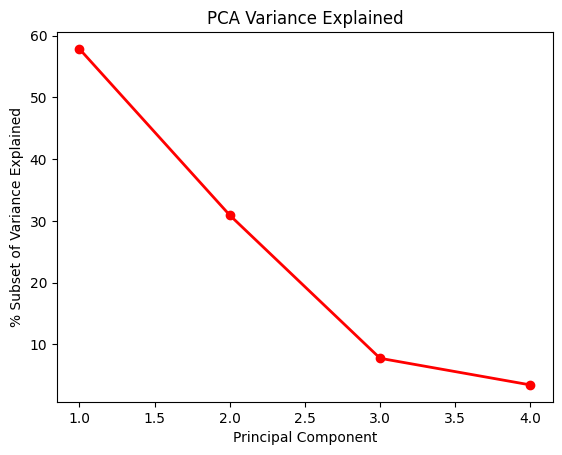

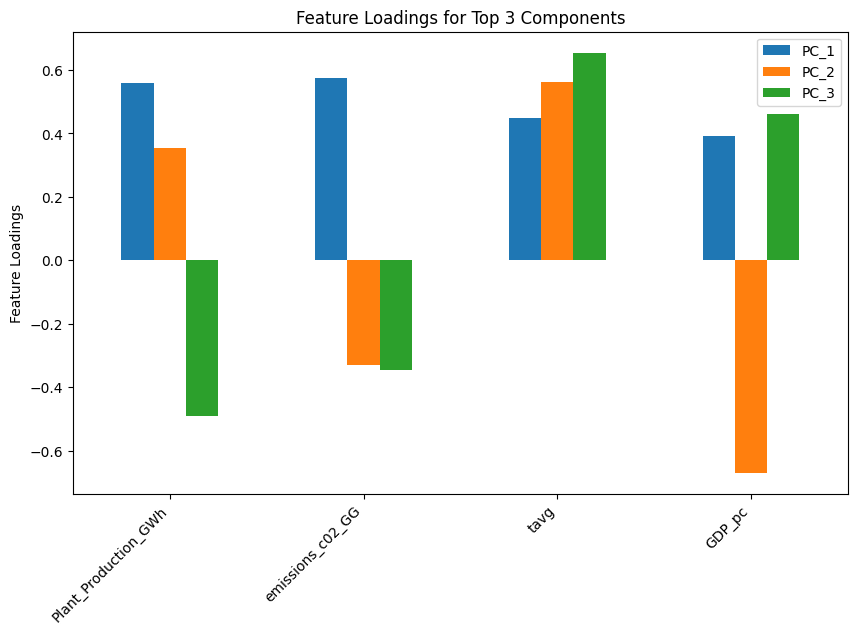

,PC_1,PC_2,PC_3
Plant_Production_GWh,0.559810,0.354807,-0.491221
emissions_c02_GG,0.575973,-0.329715,-0.345250
tavg,0.449609,0.562803,0.654418
GDP_pc,0.390793,-0.669815,0.459610


In [20]:
plt.plot(np.arange(0, len(cum_var_exp)) + 1, var_exp, "ro-", lw=2)
plt.title("PCA Variance Explained")
plt.xlabel("Principal Component")
plt.ylabel("% Subset of Variance Explained")
plt.show()

loadings = pd.DataFrame(
    eigen_vectors,
    columns=["PC_" + str(i + 1) for i in range(len(cum_var_exp))],
    index=FEATURES,
)
top_components = loadings.iloc[:, :num_components]
top_components_plot = top_components.plot(
    kind="bar",
    title=f"Feature Loadings for Top {num_components} Components",
    figsize=(10, 6),
    legend=True,
)
top_components_plot.set_ylabel("Feature Loadings")
top_components_plot.set_xticklabels(
    top_components_plot.get_xticklabels(), rotation=45, ha="right"
)
plt.show()

loadings_df = pd.DataFrame(
    top_components,
    columns=["PC_" + str(i + 1) for i in range(num_components)],
    index=FEATURES,
)
loadings_df

From the above plots:
  - Positive loading indicates a positive correlation with the principal component.
  - Negative loading indicates a negative correlation with the principal component.
  - The magnitude of the loading represents the strength of the contribution.

The the absolute loadings will hint on the importance of the feature:

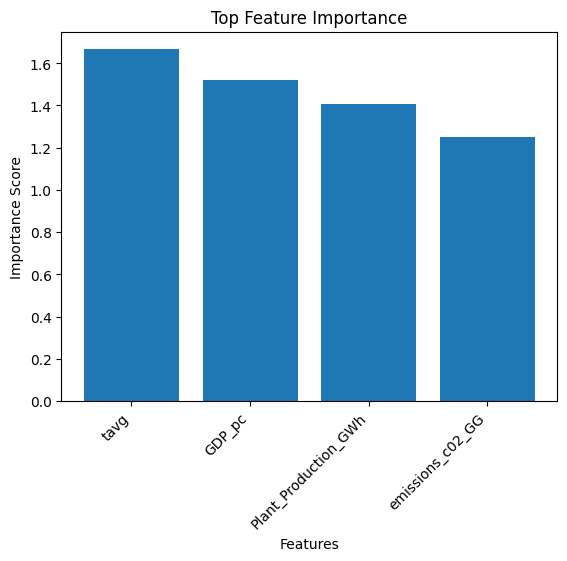

In [21]:
abs_loadings = np.abs(top_components.values)
feature_importance = abs_loadings.sum(axis=1)
sorted_features = sorted(
    zip(FEATURES, feature_importance), key=lambda x: x[1], reverse=True
)
top_features, importance_scores = zip(*sorted_features)
plt.bar(range(len(top_features)), importance_scores, tick_label=top_features)
plt.title("Top Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha="right")
plt.show()

Summing the absolute values in the Eigenvectors, we can discover which features have most information to our dataset.

NB: PCA can also be used to reduce DIMs to visualize the data better, in this case 4 DIMs to 3 DIMs. Below is using scikit learn transformers:

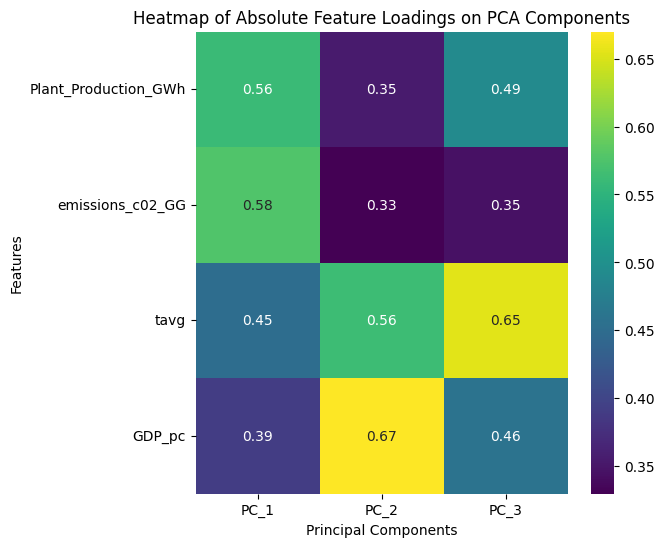

In [22]:
import seaborn as sns

abs_loadings_full = np.abs(loadings_df)

plt.figure(figsize=(6, 6))
sns.heatmap(abs_loadings_full, cmap="viridis", annot=True)
plt.title("Heatmap of Absolute Feature Loadings on PCA Components")
plt.xlabel("Principal Components")
plt.ylabel("Features")
plt.show()